<html>
<head>
	<title>Capstone Project Code</title>
</head>
<body>
	<h1>Capstone Project Code</h1>
    <h2>Pre-Processing</h2>
	<p>Import all the Python packages that will be used for the processing and analysis </p>
</body>
</html>

In [11]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from wordcloud import WordCloud
from PIL import Image
from textblob import TextBlob

Funtions to use in pre-processing the data 

In [12]:
def load_data():
    brex_data = pd.read_excel (r'C:\Users\waina\Documents\Ryerson Courses\Capstone\Capstone Code\Twitter_Brexit.xlsx')
    return brex_data

def clean_tweet(tweet):
    clean=[]
    clean = re.sub("(@[A-Za-z)-9]+)|([^)-9A-Za-z \t])|(\w+:\/\/\S+)|(\d+)"," ", tweet)
    clean = clean.lower().split()
    stops = set(stopwords.words("english"))
    stops2 = set(stopwords.words("french"))
    stops3 = set(stopwords.words("spanish"))
    stops4 = set((u'-', u'rt', u'r', u'https', u'el', u'.', u'brexit', u'brexit.', u'brexit,', u'si', u'vote', u'via', u','u'uk',u'leave',u'euref',u'eurefresults',u'voted',u'cameron',u'pm',u'referendum',u'says',u'palace',u'buckingham',u'audience',u'people',u'plan',u'cornwall',u'single',u'italy',u'referendums',u'one',u'netherlands',u'day',u'britain',u'british',u'get',u'progrexit',u'would',u'david',u'news',u'make',u'levels',u'assurances',u'boris',u'trump',u'morning',u'farage'))
    allstops = stops|stops2|stops3|stops4
    clean = [w for w in clean if not w in allstops]
    return(clean)
     
def long_lat(y):
    b = re.sub("([0-9]\+)"," ,+", str(y))
    c = re.sub("([0-9]\-)"," ,-", b)
    d = re.sub("(\/)","", c)
    return d



Load the data and process and clean the data to create a dataframe with all the data in the correct format to use for the Sentiment Analysis and the Keyword searches.

The following steps are coded:
- Load the data into a dataframe
- Drop the columns that will not be used in the analysis
- Clean the column containg the tweets by removing:
    - commonly used stopwords
    - hyperlinks
    - special characters
    - added words identified to not add value after running the code several times over
- Clean the location co-ordinates by:
    - find the rows with no location data and assigning an arbitrary value
    - split the coordinates into two columns, one for latitude and one for longitude
    - convert the columns to float values
- Use the latittude and londgitude information to identify coordinates and classify then into three areas
    - United Kingdom
    - United States (USA)
    - Other Country (Other)

In [13]:
data = load_data()
data.drop(['Row ID', 'Username', 'Time', 'Retweeted By', 'Hashtags', 'Mentions', 'Name', 'Web', 'Bio', 'Number of Tweets', 'Number of Followers','Number Following', 'Tweet ID', 'Tweet Type', 'Number of Retweets'], axis=1,inplace=True)

clean = []
for a in data['Tweet']:
    clean.append(clean_tweet(a))

data['CleanTweet'] = clean
data['CleanTweetString'] = [' '.join(map(str,l)) for l in data['CleanTweet']]
data['length'] = data['CleanTweet'].apply(len)
data = data[data.length != 0]

locat = []
for x in data['Location Coordinates']:
    locat.append(long_lat(x))
data['Lat_Long'] = locat
data['Lat_Long'] = data['Lat_Long'].replace("nan", "+10001, +10001")

new = data['Lat_Long'].str.split(",", n = 1, expand = True)
data['Lattitude'] = new[0]
data['Longitude'] = new[1]
data['Lattitude'] = data['Lattitude'].astype(float)
data['Longitude'] = data['Longitude'].astype(float)

data['con1'] = data['Lattitude'].apply(lambda x: 1 if 49.959 <= x <= 58.635 else (5 if 18.916 <= x <= 71.357 else 0))
data['con2'] = data['Longitude'].apply(lambda x: 1 if -7.572 <= x <= 1.681 else (5 if -171.7911 <= x <= -66.964 else 0))
data['con3'] = data['con1'] + data['con2']
data['Country'] = data['con3'].apply(lambda x: "United Kingdom" if x == 2 else ( "USA" if x == 10 else "Other"))

## Sentiment Analysis

Functions to be used in Senstiment Analysis

In [14]:
def flatten(li):
    flattened = []
    for item in li:
        for a in item:
            flattened.append(a)
    return(flattened)

def lst_st(st_words):
    to_string = (" ").join(st_words)
    return(to_string)
    

def freq_chart(dat):
    a = plt.hist(dat, bins=None)
    plt.gca().set(title='Frequency Histogram')
    return (a)

def summary_data(x,y):
    a = len(x[x == 1])
    b = len(x[x == 0])
    c = len(x[x == -1]) 
    d = {'Region':y,'Positive':[a],'Negative':[c],'Neutral':[b]}
    e = pd.DataFrame(d)
    e.set_index('Region', inplace=True)
    return (e)    

Perform sentiment Analysis using the TextBlob package.
    - Assign +1 to positive Tweets
    - Assign -1 to negative Tweets
    - Assign 0 to neutral Tweets
Put the results of the sentiment analysis in the dataframe
Print out the results of the sentiment analysis by region

In [15]:
data['sentiment'] = data['CleanTweetString'].apply(lambda Tweet: TextBlob(str(Tweet)).sentiment.polarity) 
data['sentimentclass'] = data['sentiment'].apply(lambda x: 1 if x > 0 else ( 0 if x == 0 else -1))

uk = data.loc[data['Country'] == "United Kingdom"]['sentimentclass']
us = data.loc[data['Country'] == "USA"]['sentimentclass']
other = data.loc[data['Country'] == "Other"]['sentimentclass']

ukresults = summary_data(uk, "United Kingdom")
usresults = summary_data(us, "United States")
otherresults = summary_data(other, "Other")
SentimentDist = ukresults.append(usresults)
SentimentDist = SentimentDist.append(otherresults)

print("The sentiment distribution for tweets by region is shown below.")

display(SentimentDist)
SentimentDist1 = SentimentDist.drop(['Neutral'], axis = 1)
SentimentDist1['Sum'] = SentimentDist1.sum(axis = 1)
SentimentDist1['Positive_%'] = SentimentDist1.Positive/SentimentDist1.Sum *100
SentimentDist1['Negative_%'] = SentimentDist1.Negative/SentimentDist1.Sum *100

display(SentimentDist1)

The sentiment distribution for tweets by region is shown below.


,Positive,Negative,Neutral
Region,,,
United Kingdom,875,349,1121
United States,486,166,704
Other,2216,1232,10205


,Positive,Negative,Sum,Positive_%,Negative_%
Region,,,,,
United Kingdom,875,349,1224,71.486928,28.513072
United States,486,166,652,74.539877,25.460123
Other,2216,1232,3448,64.269142,35.730858


## Keyword Search

Using the Natural Language Tool Kit (nltk) package perform a keyword search by:

- split the tweets by:
    - region (United Kingdom, United States and Other)
    - sentiment (Positive, Negative)
- perform a frequency distribution for all the words used in the tweets for the above splits
- select the words to include in the analysis by choosing a minimun and maximum value of the frequency at which the words are repeated
- create a Word cloud for each of the scenarios

Wordcloud for tweets form the UK


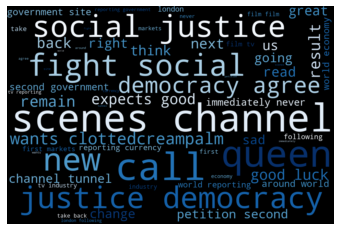

The total number of UK words after cleaning the tweets is  48


In [16]:
def Word_Cloud(lst):
    wordcloud = WordCloud(width=1280, height=853, margin=0,  colormap='Blues').generate(lst)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.show()
    return wordcloud

def clean_words(y):
    b = [x for x in y if x.isalpha()]
    return b

def word_filter(a,b):
    c = set(b)
    filtered = [w for w in a if w in c]
    return filtered

def select_words(x,low,high):
    word_freq = nltk.FreqDist(x)
    word_freq_table = pd.DataFrame(list(word_freq.items()), columns = ['Word','Frequency'])
    word_freq_table['Choose'] = word_freq_table['Frequency'].apply(lambda x: 1 if low <= x <= high else 0)
    select_words = word_freq_table.loc[word_freq_table['Choose'] != 0]['Word']
    word_freq_table.to_csv('Word_Table.csv', sep=',', mode='a')
    filtered_words = word_filter(ukTweets,select_words)
    return filtered_words

ukTweets = flatten(data.loc[data['Country'] == "United Kingdom"]['CleanTweet'])
ukTweets = clean_words(ukTweets)

usTweets = flatten(data.loc[data['Country'] == "USA"]['CleanTweet'])
usTweets = clean_words(usTweets)

otherTweets = flatten(data.loc[data['Country'] == "Other"]['CleanTweet'])
otherTweets = clean_words(otherTweets)

positiveTweets = flatten(data.loc[data['sentimentclass'] == 1]['CleanTweet'])
positiveTweets = clean_words(positiveTweets)

negativeTweets = flatten(data.loc[data['sentimentclass'] == -1]['CleanTweet'])
negativeTweets = clean_words(negativeTweets)

ukwords = select_words(ukTweets,30,100)
uswords = select_words(usTweets,21,115)
otherwords = select_words(otherTweets,80,135)
positivewords = select_words(positiveTweets,80,135)
negativewords = select_words(negativeTweets,30,142)

ukwordcount = len(set(ukwords))
uswordcount = len(set(uswords))
otherwordcount = len(set(otherwords))
positivewordcount = len(set(positivewords))
negativewordcount = len(set(negativewords))

print("Wordcloud for tweets form the UK")
Word_Cloud(lst_st(ukwords))
print('The total number of UK words after cleaning the tweets is ', ukwordcount)

Wordcloud for tweets form the US


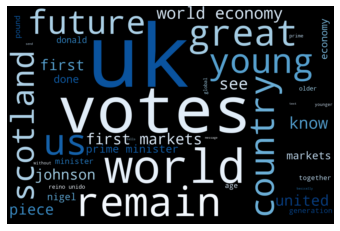

The total number of US words after cleaning the tweets is  39


In [17]:
print("Wordcloud for tweets form the US")
Word_Cloud(lst_st(uswords))
print('The total number of US words after cleaning the tweets is ', uswordcount)

Wordcloud for tweets form Other Countries


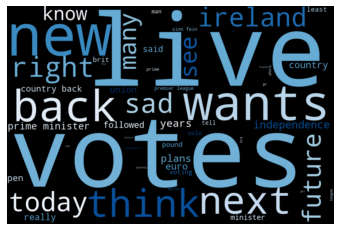

The total number of Other Country words after cleaning the tweets is  58


In [18]:
print("Wordcloud for tweets form Other Countries")
Word_Cloud(lst_st(otherwords))
print('The total number of Other Country words after cleaning the tweets is ', otherwordcount)

Wordcloud for Positive tweets


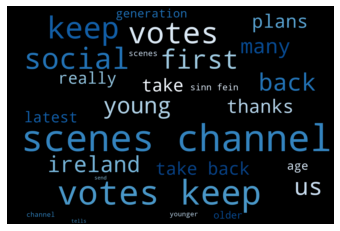

The total number of words in Positive Tweets after cleaning the tweets is  24


In [19]:
print("Wordcloud for Positive tweets")
Word_Cloud(lst_st(positivewords))
print('The total number of words in Positive Tweets after cleaning the tweets is ', positivewordcount)

Wordcloud for negative tweets


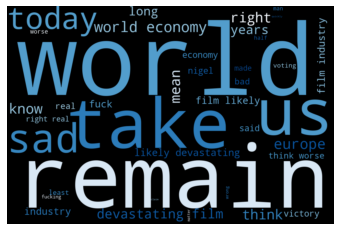

The total number of words in Negative Tweets after cleaning the tweets is  37


In [20]:
print("Wordcloud for negative tweets")
Word_Cloud(lst_st(negativewords))
print('The total number of words in Negative Tweets after cleaning the tweets is ', negativewordcount)